### CONSUMO DE API

In [1]:
#Se importan las librerías necesarias
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix

### Datos de Macroeconomía

En este apartado se buscará crear un dataaframe que contenga diferentes valores de la macroeconomía de EEUU. El daaframe tendrá por nombre ´economy´ y tendrá en columnas las siguientes métricas:

•	Unemployment.
•	Consumer price index (ipc).
•	Utilization rate 
•	Commercial balance (goods + services). 
•	Retail trade
•	Industrial production
•	Consumer confidence index
•	Producer price index
•	Government debt
•	House Price
•	Sentiment index
•	Population
•	Money supply
•	Policy rate - short term

Pagina web, datos de macroeconomía: https://www.econdb.com/api/series/?page=1

In [2]:
#Importamos librerías necesarias

import requests
import json
from pandas.io.json import json_normalize

#Importamos API de desempleo en Estados Unidos

url='https://www.econdb.com/api/series/URATEUS/?format=json'
desempleo = requests.get(url)

#Verificamos conexión
print(desempleo)

#Paso a texto el .json
texto=desempleo.text
d = json.loads(texto)

<Response [200]>


In [3]:
#me quedo con las columnas que me interesan
desempleo_values = json_normalize(data=d['data'],record_path='values')
desempleo_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
desempleo = desempleo_values.merge(desempleo_dates, how='inner', left_index=True, right_index=True)
desempleo = desempleo.rename(columns = {'0_x':'tasa_desocupacion','0_y':'fecha'})
desempleo

#creo la columna año_mes
left = desempleo['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
desempleo = aux.merge(desempleo, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
desempleo = desempleo.drop(['fecha'],axis=1)

#Llevo la tasa de desempleo de valor % a valor numérico 
desempleo['tasa_desocupacion'] = desempleo['tasa_desocupacion']/100
desempleo

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\2337598885.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  desempleo_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\2337598885.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  desempleo_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,tasa_desocupacion
0,1948-01,0.034
1,1948-02,0.038
2,1948-03,0.040
3,1948-04,0.039
4,1948-05,0.035
...,...,...
892,2022-05,0.036
893,2022-06,0.036
894,2022-07,0.035
895,2022-08,0.037


In [4]:
#Importamos API de inflación en Estados Unidos

url='https://www.econdb.com/api/series/CPIUS/?format=json'
ipc = requests.get(url)
texto=ipc.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
ipc_values = json_normalize(data=d['data'],record_path='values')
ipc_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
ipc = ipc_values.merge(ipc_dates, how='inner', left_index=True, right_index=True)
ipc = ipc.rename(columns = {'0_x':'ipc','0_y':'fecha'})

#creo la columna anio_mes
left = ipc['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
ipc = aux.merge(ipc, how='inner', left_index=True, right_index=True)
#eliminamos columna fecha
ipc = ipc.drop(['fecha'],axis=1)
#divido el porcentaje por 100
ipc['ipc'] = ipc['ipc']/100
#Creo la columna anio
left2 = ipc['anio_mes'].str[:4]
aux2 = pd.DataFrame(left2)
aux2 = aux2.rename(columns = {'anio_mes':'anio'})
ipc = aux2.merge(ipc, how='inner', left_index=True, right_index=True)
#Creo la columna mes
right3 = ipc['anio_mes'].str[5:]
aux3 = pd.DataFrame(right3)
aux3 = aux3.rename(columns = {'anio_mes':'mes'})
ipc = aux3.merge(ipc, how='inner', left_index=True, right_index=True)

ipc

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\2924311085.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  ipc_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\2924311085.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  ipc_dates = json_normalize(data=d['data'],record_path='dates')


,mes,anio,anio_mes,ipc
0,01,1947,1947-01,0.2148
1,02,1947,1947-02,0.2162
2,03,1947,1947-03,0.2200
3,04,1947,1947-04,0.2200
4,05,1947,1947-05,0.2195
...,...,...,...,...
904,05,2022,2022-05,2.9150
905,06,2022,2022-06,2.9530
906,07,2022,2022-07,2.9530
907,08,2022,2022-08,2.9560


In [5]:
#Bucle para crear la columna ipc_anual
ipc2 = ipc
ipc_anual = []
for index, row in ipc2.iterrows():  
    anio_mes = row['anio_mes']
    ipc = row['ipc']
    if anio_mes == '1947-01':
        aux = ipc
    else:
        aux = ipc - ipc_anterior
    ipc_anterior = ipc
    ipc_anual.append(aux)
ipc2['ipc_anual'] = ipc_anual

ipc2

,mes,anio,anio_mes,ipc,ipc_anual
0,01,1947,1947-01,0.2148,0.2148
1,02,1947,1947-02,0.2162,0.0014
2,03,1947,1947-03,0.2200,0.0038
3,04,1947,1947-04,0.2200,0.0000
4,05,1947,1947-05,0.2195,-0.0005
...,...,...,...,...,...
904,05,2022,2022-05,2.9150,0.0280
905,06,2022,2022-06,2.9530,0.0380
906,07,2022,2022-07,2.9530,0.0000
907,08,2022,2022-08,2.9560,0.0030


In [6]:
#Importamos API de Utilization rate en Estados Unidos (%)
url='https://www.econdb.com/api/series/UTILUS/?format=json'
utili_rate = requests.get(url)
texto=utili_rate.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
utili_rate_values = json_normalize(data=d['data'],record_path='values')
utili_rate_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
utili_rate = utili_rate_values.merge(utili_rate_dates, how='inner', left_index=True, right_index=True)
utili_rate = utili_rate.rename(columns = {'0_x':'utili_rate','0_y':'fecha'})

#creo la columna año_mes
left = utili_rate['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
utili_rate = aux.merge(utili_rate, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
utili_rate = utili_rate.drop(['fecha'],axis=1)
#divido el porcentaje por 100
utili_rate['utili_rate'] = utili_rate['utili_rate']/100

utili_rate

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\3823498321.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  utili_rate_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\3823498321.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  utili_rate_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,utili_rate
0,1967-01,0.8939
1,1967-02,0.8797
2,1967-03,0.8708
3,1967-04,0.8751
4,1967-05,0.8636
...,...,...
664,2022-05,0.8004
665,2022-06,0.7984
666,2022-07,0.8030
667,2022-08,0.8014


In [7]:
#Importamos API de Commercial balance (goods + services) en Estados Unidos (Billons USD)

url='https://www.econdb.com/api/series/CBALUS/?format=json'
comercial_balance = requests.get(url)
texto=comercial_balance.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
comercial_balance_values = json_normalize(data=d['data'],record_path='values')
comercial_balance_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
comercial_balance = comercial_balance_values.merge(comercial_balance_dates, how='inner', left_index=True, right_index=True)
comercial_balance = comercial_balance.rename(columns = {'0_x':'comercial_balance','0_y':'fecha'})

#creo la columna año_mes
left = comercial_balance['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
comercial_balance = aux.merge(comercial_balance, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
comercial_balance = comercial_balance.drop(['fecha'],axis=1)
#multiplico para pasar de billion a dolares
comercial_balance['comercial_balance'] = comercial_balance['comercial_balance']*1000000000
comercial_balance

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\2071714972.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  comercial_balance_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\2071714972.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  comercial_balance_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,comercial_balance
0,2009-01,-4.670000e+10
1,2009-02,-3.690000e+10
2,2009-03,-3.840000e+10
3,2009-04,-3.950000e+10
4,2009-05,-3.540000e+10
...,...,...
159,2022-04,-1.068000e+11
160,2022-05,-1.035000e+11
161,2022-06,-9.910000e+10
162,2022-07,-9.020000e+10


In [8]:
#Importamos API de Retail trade en Estados Unidos

url='https://www.econdb.com/api/series/RETAUS/?format=json'
rt = requests.get(url)
texto=rt.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
rt_values = json_normalize(data=d['data'],record_path='values')
rt_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
rt = rt_values.merge(rt_dates, how='inner', left_index=True, right_index=True)
rt = rt.rename(columns = {'0_x':'rt','0_y':'fecha'})

#creo la columna año_mes
left = rt['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
rt = aux.merge(rt, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
rt = rt.drop(['fecha'],axis=1)

rt

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\650749122.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  rt_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\650749122.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  rt_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,rt
0,1992-01,146925
1,1992-02,147223
2,1992-03,146805
3,1992-04,148032
4,1992-05,149010
...,...,...
364,2022-05,591793
365,2022-06,598145
366,2022-07,595894
367,2022-08,597230


In [9]:
#Importamos API de Industrial production en Estados Unidos

url='https://www.econdb.com/api/series/IPUS/?format=json'
ind_pro = requests.get(url)
texto=ind_pro.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
ind_pro_values = json_normalize(data=d['data'],record_path='values')
ind_pro_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
ind_pro = ind_pro_values.merge(ind_pro_dates, how='inner', left_index=True, right_index=True)
ind_pro = ind_pro.rename(columns = {'0_x':'ind_pro','0_y':'fecha'})

#creo la columna año_mes
left = ind_pro['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
ind_pro = aux.merge(ind_pro, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
ind_pro = ind_pro.drop(['fecha'],axis=1)

ind_pro

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\1208842150.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  ind_pro_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\1208842150.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  ind_pro_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,ind_pro
0,1940-01,8.542
1,1940-02,8.273
2,1940-03,8.084
3,1940-04,8.246
4,1940-05,8.488
...,...,...
988,2022-05,104.200
989,2022-06,104.100
990,2022-07,104.900
991,2022-08,104.800


In [10]:
#Importamos API de Real gross domestic product en Estados Unidos

url='https://www.econdb.com/api/series/IPUS/?format=json'
rgdp = requests.get(url)
texto=rgdp.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
rgdp_values = json_normalize(data=d['data'],record_path='values')
rgdp_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
rgdp = rgdp_values.merge(rgdp_dates, how='inner', left_index=True, right_index=True)
rgdp = rgdp.rename(columns = {'0_x':'rgdp','0_y':'fecha'})

#creo la columna año_mes
left = rgdp['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
rgdp = aux.merge(rgdp, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
rgdp = rgdp.drop(['fecha'],axis=1)
#multiplico para pasar de million a dolares
rgdp['rgdp'] = rgdp['rgdp']*1000000
rgdp

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\364126333.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  rgdp_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\364126333.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  rgdp_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,rgdp
0,1940-01,8542000.0
1,1940-02,8273000.0
2,1940-03,8084000.0
3,1940-04,8246000.0
4,1940-05,8488000.0
...,...,...
988,2022-05,104200000.0
989,2022-06,104100000.0
990,2022-07,104900000.0
991,2022-08,104800000.0


In [11]:
#Importamos API de Consumer confidence index en Estados Unidos

url='https://www.econdb.com/api/series/CONFUS/?format=json'
cc_index = requests.get(url)
texto=cc_index.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
cc_index_values = json_normalize(data=d['data'],record_path='values')
cc_index_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
cc_index = cc_index_values.merge(cc_index_dates, how='inner', left_index=True, right_index=True)
cc_index = cc_index.rename(columns = {'0_x':'cc_index','0_y':'fecha'})

#creo la columna año_mes
left = cc_index['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
cc_index = aux.merge(cc_index, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
cc_index = cc_index.drop(['fecha'],axis=1)

cc_index

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\915007642.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  cc_index_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\915007642.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  cc_index_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,cc_index
0,1960-01,107.60
1,1960-02,105.20
2,1960-03,102.80
3,1960-04,100.40
4,1960-05,101.80
...,...,...
745,2022-02,67.57
746,2022-03,63.91
747,2022-04,70.15
748,2022-05,62.84


In [12]:
#Importamos API de Producer price index en Estados Unidos

url='https://www.econdb.com/api/series/PPIUS/?format=json'
pp_index = requests.get(url)
texto=pp_index.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
pp_index_values = json_normalize(data=d['data'],record_path='values')
pp_index_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
pp_index = pp_index_values.merge(pp_index_dates, how='inner', left_index=True, right_index=True)
pp_index = pp_index.rename(columns = {'0_x':'pp_index','0_y':'fecha'})

#creo la columna año_mes
left = pp_index['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
pp_index = aux.merge(pp_index, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
pp_index = pp_index.drop(['fecha'],axis=1)

pp_index

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\559633029.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  pp_index_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\559633029.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  pp_index_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,pp_index
0,2014-07,111.3
1,2014-08,111.3
2,2014-09,111.1
3,2014-10,111.3
4,2014-11,111.1
...,...,...
94,2022-05,139.1
95,2022-06,140.5
96,2022-07,139.9
97,2022-08,139.7


In [13]:
#Importamos API de Government debt en Estados Unidos

url='https://www.econdb.com/api/series/GDEBTUS/?format=json'
gov_debt = requests.get(url)
texto=gov_debt.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
gov_debt_values = json_normalize(data=d['data'],record_path='values')
gov_debt_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
gov_debt = gov_debt_values.merge(gov_debt_dates, how='inner', left_index=True, right_index=True)
gov_debt = gov_debt.rename(columns = {'0_x':'gov_debt','0_y':'fecha'})

#creo la columna año_mes
left = gov_debt['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
gov_debt = aux.merge(gov_debt, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
gov_debt = gov_debt.drop(['fecha'],axis=1)
#multiplico para pasar de million a dolares
gov_debt['gov_debt'] = gov_debt['gov_debt']*1000000

gov_debt

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\1131182723.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  gov_debt_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\1131182723.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  gov_debt_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,gov_debt
0,2001-03,5773740000000
1,2001-04,5661348000000
2,2001-05,5656182000000
3,2001-06,5726815000000
4,2001-07,5718302000000
...,...,...
254,2022-05,30499620000000
255,2022-06,30568582000000
256,2022-07,30595108000000
257,2022-08,30936076000000


In [14]:
#Importamos API de House price en Estados Unidos

url='https://www.econdb.com/api/series/HOUUS/?format=json'
house_price = requests.get(url)
texto=house_price.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
house_price_values = json_normalize(data=d['data'],record_path='values')
house_price_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
house_price = house_price_values.merge(house_price_dates, how='inner', left_index=True, right_index=True)
house_price = house_price.rename(columns = {'0_x':'house_price','0_y':'fecha'})

#creo la columna año_mes
left = house_price['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
house_price = aux.merge(house_price, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
house_price = house_price.drop(['fecha'],axis=1)

house_price

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\3567205072.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  house_price_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\3567205072.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  house_price_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,house_price
0,1991-01,100.0
1,1991-02,100.5
2,1991-03,100.5
3,1991-04,100.3
4,1991-05,100.4
...,...,...
375,2022-04,392.3
376,2022-05,396.9
377,2022-06,397.1
378,2022-07,394.6


In [15]:
#Importamos API de Sentiment index en Estados Unidos

url='https://www.econdb.com/api/series/SENTUS/?format=json'
sentiment_index = requests.get(url)
texto=sentiment_index.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
sentiment_index_values = json_normalize(data=d['data'],record_path='values')
sentiment_index_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
sentiment_index = sentiment_index_values.merge(sentiment_index_dates, how='inner', left_index=True, right_index=True)
sentiment_index = sentiment_index.rename(columns = {'0_x':'sentiment_index','0_y':'fecha'})

#creo la columna año_mes
left = sentiment_index['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
sentiment_index = aux.merge(sentiment_index, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
sentiment_index = sentiment_index.drop(['fecha'],axis=1)

sentiment_index

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\4077192386.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  sentiment_index_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\4077192386.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  sentiment_index_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,sentiment_index
0,1969-01,43.0
1,1969-02,28.2
2,1969-03,35.7
3,1969-04,33.7
4,1969-05,-3.5
...,...,...
641,2022-06,-6.8
642,2022-07,-18.6
643,2022-08,-10.6
644,2022-09,-3.9


In [16]:
#Importamos API de Population en Estados Unidos

url='https://www.econdb.com/api/series/POPUS/?format=json'
population = requests.get(url)
texto=population.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
population_values = json_normalize(data=d['data'],record_path='values')
population_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
population = population_values.merge(population_dates, how='inner', left_index=True, right_index=True)
population = population.rename(columns = {'0_x':'population','0_y':'fecha'})

#creo la columna año_mes
left = population['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
population = aux.merge(population, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
population = population.drop(['fecha'],axis=1)
#multiplico para pasar de miles de personas a personas
population['population'] = population['population']*1000
population

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\3912958797.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  population_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\3912958797.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  population_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,population
0,1952-01,156309000
1,1952-02,156527000
2,1952-03,156731000
3,1952-04,156943000
4,1952-05,157140000
...,...,...
811,2019-08,328730000
812,2019-09,328897000
813,2019-10,329054000
814,2019-11,329191000


In [17]:
#Importamos API de Money supply en Estados Unidos

url='https://www.econdb.com/api/series/M3US/?format=json'
money_supply = requests.get(url)
texto=money_supply.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
money_supply_values = json_normalize(data=d['data'],record_path='values')
money_supply_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
money_supply = money_supply_values.merge(money_supply_dates, how='inner', left_index=True, right_index=True)
money_supply = money_supply.rename(columns = {'0_x':'money_supply','0_y':'fecha'})

#creo la columna año_mes
left = money_supply['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
money_supply = aux.merge(money_supply, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
money_supply = money_supply.drop(['fecha'],axis=1)
#multiplico para pasar de billion a dolares
money_supply['money_supply'] = money_supply['money_supply']*1000000000
money_supply

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\1384868698.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  money_supply_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\1384868698.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  money_supply_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,money_supply
0,1959-01,2.898000e+11
1,1959-02,2.877000e+11
2,1959-03,2.879000e+11
3,1959-04,2.902000e+11
4,1959-05,2.902000e+11
...,...,...
760,2022-05,2.155500e+13
761,2022-06,2.158600e+13
762,2022-07,2.157900e+13
763,2022-08,2.154600e+13


In [18]:
#Importamos API de Policy rate - short term and services en Estados Unidos (%)

url='https://www.econdb.com/api/series/POLIRUS/?format=json'
policy = requests.get(url)
texto=policy.text
d = json.loads(texto)

#me quedo con las columnas de la API que me interesan
policy_values = json_normalize(data=d['data'],record_path='values')
policy_dates = json_normalize(data=d['data'],record_path='dates')

#unifico las columnas que me interesan en un único df
policy = policy_values.merge(policy_dates, how='inner', left_index=True, right_index=True)
policy = policy.rename(columns = {'0_x':'policy','0_y':'fecha'})

#creo la columna año_mes
left = policy['fecha'].str[:7]
aux = pd.DataFrame(left)
aux = aux.rename(columns = {'fecha':'anio_mes'})
policy = aux.merge(policy, how='inner', left_index=True, right_index=True)

#eliminamos columna fecha
policy = policy.drop(['fecha'],axis=1)
#divido el porcentaje por 100
policy['policy'] = policy['policy']/100

policy

C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\747646867.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  policy_values = json_normalize(data=d['data'],record_path='values')
C:\Users\GUILLERMO\AppData\Local\Temp\ipykernel_6284\747646867.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  policy_dates = json_normalize(data=d['data'],record_path='dates')


,anio_mes,policy
0,1954-07,0.0080
1,1954-08,0.0122
2,1954-09,0.0107
3,1954-10,0.0085
4,1954-11,0.0083
...,...,...
814,2022-05,0.0077
815,2022-06,0.0121
816,2022-07,0.0168
817,2022-08,0.0233


In [19]:
# Uno toda la información en un único dataframe
economy = pd.merge(ipc2, utili_rate, how='left', on = 'anio_mes')
economy = pd.merge(desempleo, economy, how='right', on = 'anio_mes')
economy = pd.merge(comercial_balance, economy, how='right', on = 'anio_mes')
economy = pd.merge(rt, economy, how='right', on = 'anio_mes')
economy = pd.merge(ind_pro, economy, how='right', on = 'anio_mes')
economy = pd.merge(rgdp, economy, how='right', on = 'anio_mes')
economy = pd.merge(cc_index, economy, how='right', on = 'anio_mes')
economy = pd.merge(pp_index, economy, how='right', on = 'anio_mes')
economy = pd.merge(gov_debt, economy, how='right', on = 'anio_mes')
economy = pd.merge(house_price, economy, how='right', on = 'anio_mes')
economy = pd.merge(sentiment_index, economy, how='right', on = 'anio_mes')
economy = pd.merge(population, economy, how='right', on = 'anio_mes')
economy = pd.merge(money_supply, economy, how='right', on = 'anio_mes')
economy = pd.merge(policy, economy, how='right', on = 'anio_mes')

economy

#Envío el dataframe a un Excel - para resguardarlo
economy.to_excel('economy.xlsx')

In [20]:
#normalizo el dataframe
economy_norm = economy
MM = MinMaxScaler()
economy_norm[['money_supply', 'population', 'sentiment_index',
       'house_price', 'gov_debt', 'pp_index', 'cc_index', 'rgdp', 'ind_pro',
       'rt', 'comercial_balance','ipc', 'utili_rate']]= MM.fit_transform(economy[['money_supply', 'population', 'sentiment_index',
       'house_price', 'gov_debt', 'pp_index', 'cc_index', 'rgdp', 'ind_pro',
       'rt', 'comercial_balance','ipc', 'utili_rate']])

In [21]:
economy_norm

,anio_mes,policy,money_supply,population,sentiment_index,house_price,gov_debt,pp_index,cc_index,rgdp,ind_pro,rt,comercial_balance,tasa_desocupacion,mes,anio,ipc,ipc_anual,utili_rate
0,1947-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005326,0.005326,NaN,NaN,NaN,01,1947,0.000000,0.2148,NaN
1,1947-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006196,0.006196,NaN,NaN,NaN,02,1947,0.000508,0.0014,NaN
2,1947-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007065,0.007065,NaN,NaN,NaN,03,1947,0.001889,0.0038,NaN
3,1947-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005870,0.005870,NaN,NaN,NaN,04,1947,0.001889,0.0000,NaN
4,1947-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006522,0.006522,NaN,NaN,NaN,05,1947,0.001707,-0.0005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,2022-05,0.0077,0.986044,NaN,0.322877,0.999327,0.982735,0.954693,0.135532,0.989130,0.989130,0.985926,0.245847,0.036,05,2022,0.980750,0.0280,0.623894
905,2022-06,0.0121,0.987482,NaN,0.251721,1.000000,0.985463,1.000000,0.000000,0.988043,0.988043,1.000000,0.294574,0.036,06,2022,0.994552,0.0380,0.615849
906,2022-07,0.0168,0.987157,NaN,0.161438,0.991585,0.986512,0.980583,NaN,0.996739,0.996739,0.995013,0.393134,0.035,07,2022,0.994552,0.0000,0.634352
907,2022-08,0.0233,0.985627,NaN,0.222647,0.982834,1.000000,0.974110,NaN,0.995652,0.995652,0.997973,0.425249,0.037,08,2022,0.995641,0.0030,0.627916


### EJEMPLOS GRÁFICOS API

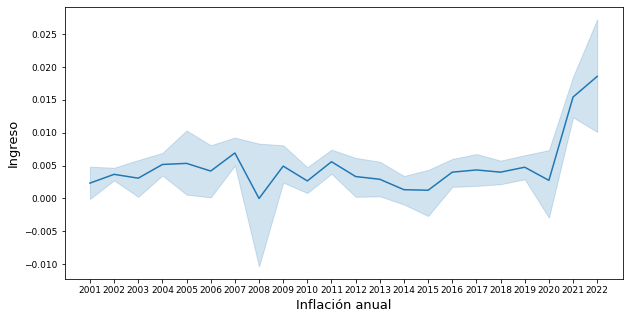

In [22]:
fig_dims = (10,5)
fix, ax = plt.subplots(figsize = fig_dims)
b1=sns.lineplot(x=economy.loc[economy['anio']>'2000']['anio'], y='ipc_anual', data=economy,palette = 'Set1')

#b1 = sns.boxplot(data = df_unicos, x = 'name_education_type', y = 'amt_income_total', palette = 'Set1', showfliers = False)
b1.set_xlabel('Inflación anual', fontsize = 13)
b1.set_ylabel('Ingreso', fontsize = 13)
b1.tick_params(labelsize = 9)


plt.show()

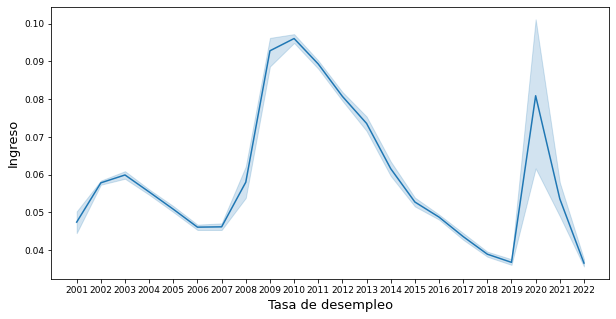

In [23]:
fig_dims = (10,5)
fix, ax = plt.subplots(figsize = fig_dims)
b1=sns.lineplot(x=economy.loc[economy['anio']>'2000']['anio'], y='tasa_desocupacion', data=economy,palette = 'Set1')

#b1 = sns.boxplot(data = df_unicos, x = 'name_education_type', y = 'amt_income_total', palette = 'Set1', showfliers = False)
b1.set_xlabel('Tasa de desempleo', fontsize = 13)
b1.set_ylabel('Ingreso', fontsize = 13)
b1.tick_params(labelsize = 9)


plt.show()